# Proyek Analisis Data: Analisis Penggunaan Model Bahasa (LLM)

- **Nama:** Rafli Arrasyid
- **Email:** rafly111104@gmail.com

## Latar Belakang Proyek

Seiring dengan pesatnya perkembangan *Large Language Models* (LLM), analisis mengenai bagaimana model-model ini digunakan dan dipersepsikan oleh pengguna menjadi sangat penting. Proyek ini bertujuan untuk menganalisis data percakapan dari berbagai model AI untuk memahami tren popularitas, pola interaksi, dan tingkat kepuasan pengguna.

## Sumber Data

Analisis ini menggunakan dua dataset publik yang disediakan oleh **Large Model Systems Organization (LMSYS Org)**:

1.  **[LMSYS-Chat-1M](https://huggingface.co/datasets/lmsys/lmsys-chat-1m):** Berisi 1 juta percakapan anonim dari 25 model AI terkemuka. Dataset ini digunakan untuk menganalisis popularitas dan pola interaksi.
2.  **[Chatbot Arena Conversations](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations):** Berisi percakapan dengan sistem pemungutan suara (voting), di mana pengguna memilih respons AI yang lebih baik. Dataset ini digunakan sebagai proksi untuk mengukur kepuasan dan preferensi pengguna.

# Pertanyaan Bisnis

**Popularitas Model:**
- 1. Model AI mana yang paling sering digunakan atau paling populer di antara pengguna?

**Analisis Topik Percakapan:**
- 2. Apa saja topik atau jenis tugas yang paling sering diminta oleh pengguna kepada model-model AI tersebut (misalnya: pemrograman, penulisan kreatif, tanya jawab umum)?

**Perbandingan Kualitas:**
- 3. Apakah ada perbedaan dalam panjang percakapan atau pola interaksi yang menunjukkan kepuasan pengguna terhadap model tertentu?


<!-- - **Specific**: What is the total count of rental bikes (cnt) for the year 2012 during the fall season (season 3)?
- **Measurable**: How many rental bikes were used on holidays (holiday = 1) during the summer season (season 2) in 2011?
- **Action-oriented**: How can we increase the number of rental bikes used by casual users (casual) on weekdays (workingday = 1)?
- **Relevant**: 
    - What is the relationship between temperature (temp) and the number of registered users (registered)?
    - What effect does the weather (weathersit) have on the number of bicycle rentals (cnt) during autumn (season 3)?
- **Time-bound**: What was the hourly distribution of rental bikes (cnt) on Christmas Day (holiday = 1) in 2012 (yr = 1)? -->

# Menyiapkan semua library yang dibutuhkan

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset 
import streamlit as st
import numpy as np
from collections import Counter
import re

# Data Wrangling

## Gathering Data 

In [11]:
# Memuat 1000 baris data sebagai sampel awal yang lebih ringan
dataset = load_dataset("lmsys/lmsys-chat-1m", split='train[:1000]')
df = pd.DataFrame(dataset)

# Menampilkan 5 baris pertama untuk memastikan data berhasil dimuat
print("Data berhasil dimuat (1000 baris). Berikut 5 baris pertama:")
print(df.head())

Data berhasil dimuat (1000 baris). Berikut 5 baris pertama:
                    conversation_id         model  \
0  33f01939a744455c869cb234afca47f1  wizardlm-13b   
1  1e230e55efea4edab95db9cb87f6a9cb    vicuna-13b   
2  0f623736051f4a48a506fd5933563cfd    vicuna-13b   
3  e5c923a7fa3f4893beb432b4a06ef222        palm-2   
4  8ad66650dced4b728de1d14bb04657c1    vicuna-13b   

                                        conversation  turn language  \
0  [{'content': 'how can identity protection serv...     1  English   
1  [{'content': 'Beside OFAC's selective sanction...     6  English   
2  [{'content': 'You are the text completion mode...     1  English   
3  [{'content': 'The sum of the perimeters of thr...     2  English   
4  [{'content': 'What is the type of the variable...     1  English   

                                   openai_moderation  redacted  
0  [{'categories': {'harassment': False, 'harassm...     False  
1  [{'categories': {'harassment': False, 'harassm...     False  

## Assessing Data

In [12]:
# Informasi dasar tentang dataset
df.info()

# Memeriksa nilai yang hilang
df.isnull().sum()

# Melihat distribusi model AI yang digunakan
print("Distribusi Model AI:")
print(df['model'].value_counts())

# Melihat distribusi bahasa yang digunakan
print("\nDistribusi Bahasa:")
print(df['language'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   conversation_id    1000 non-null   object
 1   model              1000 non-null   object
 2   conversation       1000 non-null   object
 3   turn               1000 non-null   int64 
 4   language           1000 non-null   object
 5   openai_moderation  1000 non-null   object
 6   redacted           1000 non-null   bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 48.0+ KB
Distribusi Model AI:
model
vicuna-13b                 504
koala-13b                   93
alpaca-13b                  55
llama-2-13b-chat            30
vicuna-33b                  30
chatglm-6b                  27
oasst-pythia-12b            27
llama-13b                   25
dolly-v2-12b                23
mpt-7b-chat                 21
fastchat-t5-3b              20
vicuna-7b                   20
RWKV-4-Raven-

## Cleaning Data

In [13]:
# Mengubah tipe data kolom 'model' menjadi category untuk efisiensi memori
df['model'] = df['model'].astype('category')
df['language'] = df['language'].astype('category')

# Memverifikasi tipe data setelah diubah
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   conversation_id    1000 non-null   object  
 1   model              1000 non-null   category
 2   conversation       1000 non-null   object  
 3   turn               1000 non-null   int64   
 4   language           1000 non-null   category
 5   openai_moderation  1000 non-null   object  
 6   redacted           1000 non-null   bool    
dtypes: bool(1), category(2), int64(1), object(3)
memory usage: 36.3+ KB


# Visualization & Explanatory Analysis

## Pertanyaan 1: Model AI mana yang paling populer?

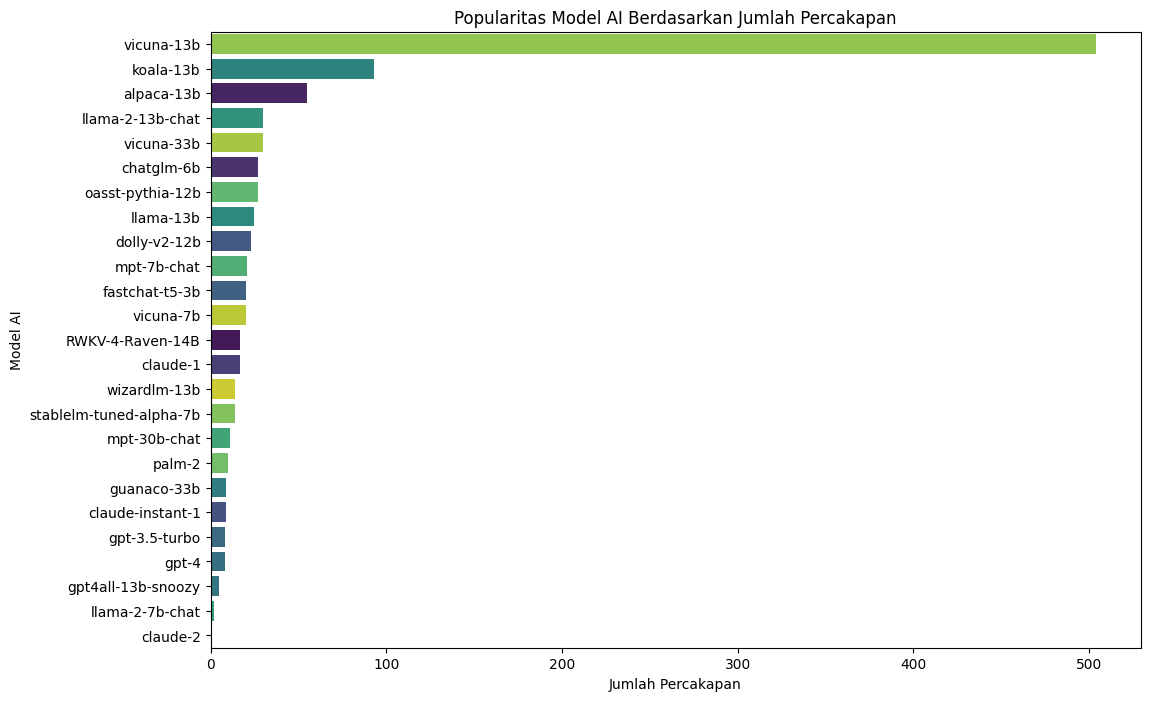

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(
    y=df['model'], 
    order=df['model'].value_counts().index, 
    palette='viridis',
    hue=df['model'], 
    legend=False 
)
plt.title('Popularitas Model AI Berdasarkan Jumlah Percakapan')
plt.xlabel('Jumlah Percakapan')
plt.ylabel('Model AI')
plt.show()

## Pertanyaan 2: Apa saja topik atau jenis tugas yang paling sering diminta oleh pengguna kepada model-model AI tersebut (misalnya: pemrograman, penulisan kreatif, tanya jawab umum)?

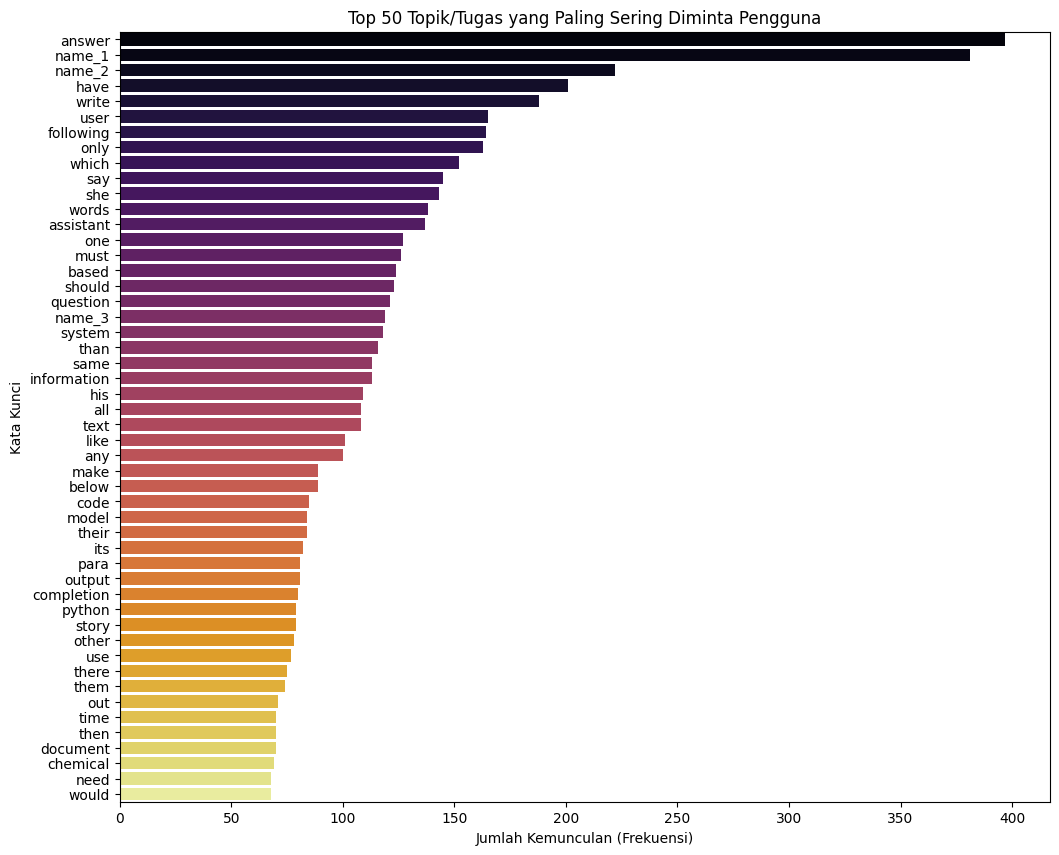

In [15]:
# 1. Ekstrak semua teks dari peran 'user'
user_texts = []
for conv in df['conversation']:
    for message in conv:
        if message['role'] == 'user':
            user_texts.append(message['content'])

# 2. Gabungkan semua teks menjadi satu string besar dan bersihkan
full_text = ' '.join(user_texts).lower()
# Hapus semua karakter non-alfanumerik kecuali spasi
full_text = re.sub(r'[^\w\s]', '', full_text)

# 3. Pisahkan menjadi kata-kata dan hapus stopwords (kata umum dalam Bahasa Inggris)
# Daftar stopwords sederhana untuk analisis ini
stopwords = set([
    'the', 'a', 'an', 'in', 'is', 'it', 'of', 'and', 'to', 'for', 'on', 'with', 'that', 'this',
    'i', 'you', 'me', 'my', 'what', 'who', 'when', 'where', 'why', 'how', 'can', 'please',
    'tell', 'give', 'about', 'some', 'do', 'does', 'did', 'are', 'was', 'were', 'be', 'die', 'name',
    'your', 'new', 'more', 'from', 'her', 'will', 'been', 'but', 'has', 'they', 'he', 'not', 'que'
])

words = [word for word in full_text.split() if word not in stopwords and len(word) > 2]

# 4. Hitung 50 kata kunci yang paling umum
word_counts = Counter(words)
top_50_words = word_counts.most_common(50)

# Ubah ke DataFrame untuk plotting
df_top_words = pd.DataFrame(top_50_words, columns=['Kata Kunci', 'Frekuensi'])

# 5. Buat visualisasi dengan diagram batang horizontal
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Frekuensi', 
    y='Kata Kunci', 
    data=df_top_words, 
    palette='inferno',
    hue='Kata Kunci',  
    legend=False
)
plt.title('Top 50 Topik/Tugas yang Paling Sering Diminta Pengguna')
plt.xlabel('Jumlah Kemunculan (Frekuensi)')
plt.ylabel('Kata Kunci')
plt.show()

### Pertanyaan 3: Apakah ada perbedaan dalam panjang percakapan atau pola interaksi yang menunjukkan kepuasan pengguna terhadap model tertentu?

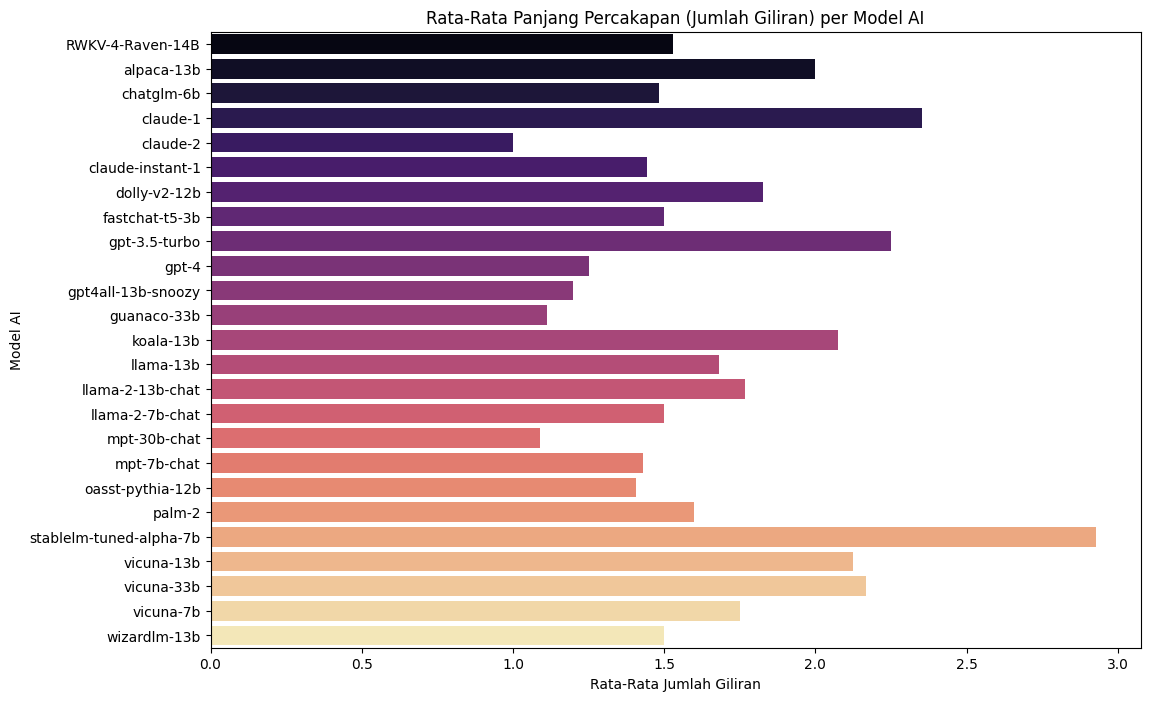

In [16]:
# Tambahkan observed=False untuk menghilangkan peringatan pandas
avg_turns_by_model = df.groupby('model', observed=False)['turn'].mean().sort_values(ascending=False)

# Membuat plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=avg_turns_by_model.values,
    y=avg_turns_by_model.index,
    palette='magma',
    hue=avg_turns_by_model.index, 
    legend=False 
)
plt.title('Rata-Rata Panjang Percakapan (Jumlah Giliran) per Model AI')
plt.xlabel('Rata-Rata Jumlah Giliran')
plt.ylabel('Model AI')
plt.show()

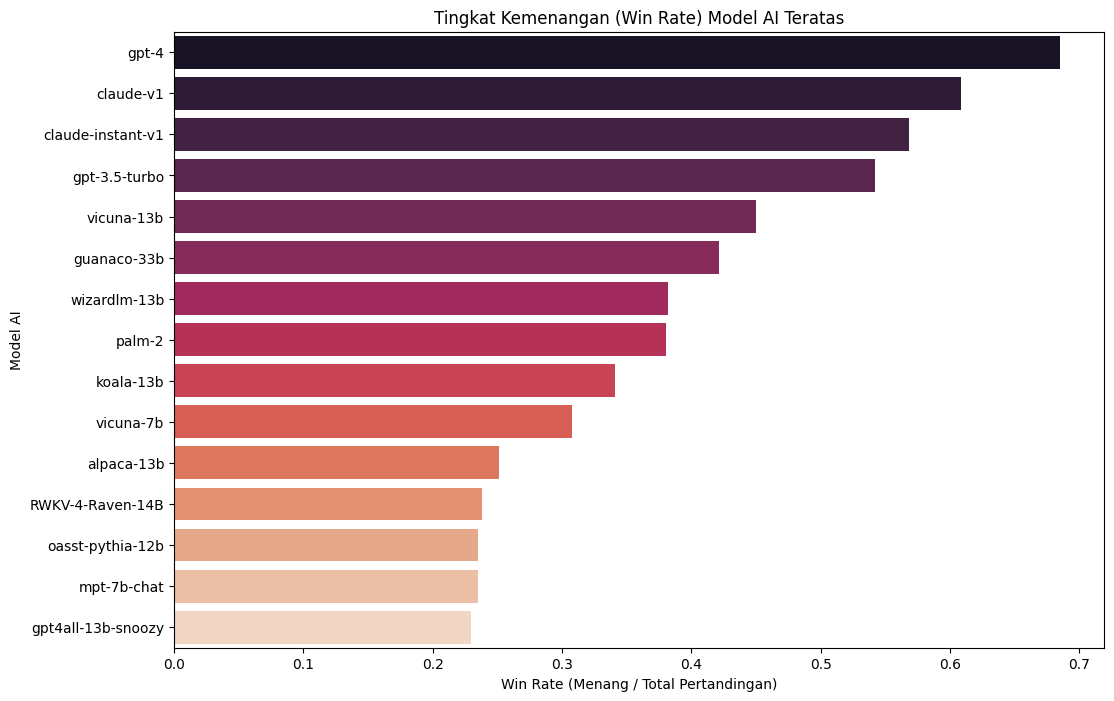

In [17]:
# Memuat dataset baru yang berisi data voting/preferensi pengguna
arena_dataset = load_dataset("lmsys/chatbot_arena_conversations", split='train')
df_arena = pd.DataFrame(arena_dataset)

# Menghitung jumlah kemenangan untuk model A dan model B
wins_a = df_arena[df_arena['winner'] == 'model_a']['model_a'].value_counts()
wins_b = df_arena[df_arena['winner'] == 'model_b']['model_b'].value_counts()

# Menggabungkan total kemenangan
total_wins = wins_a.add(wins_b, fill_value=0)

# Menghitung total berapa kali setiap model muncul (bertanding)
appearances_a = df_arena['model_a'].value_counts()
appearances_b = df_arena['model_b'].value_counts()
total_appearances = appearances_a.add(appearances_b, fill_value=0)

# Menghitung win rate (tingkat kemenangan)
win_rate = (total_wins / total_appearances).sort_values(ascending=False)

# Mengambil 15 model teratas untuk visualisasi
top_15_win_rate = win_rate.nlargest(15)

# Membuat plot untuk win rate
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_15_win_rate.values,
    y=top_15_win_rate.index,
    palette='rocket',
    hue=top_15_win_rate.index, 
    legend=False 
)
plt.title('Tingkat Kemenangan (Win Rate) Model AI Teratas')
plt.xlabel('Win Rate (Menang / Total Pertandingan)')
plt.ylabel('Model AI')
plt.show()

## CONCLUSION

### Pertanyaan 1: Model AI Mana yang Paling Populer?
Berdasarkan analisis frekuensi penggunaan dalam dataset, vicuna-13b secara jelas menempati posisi sebagai model yang paling populer di antara para pengguna. Dengan jumlah percakapan yang melebihi 500 sesi, model ini menunjukkan dominasi yang signifikan dibandingkan model lainnya. Popularitas vicuna-13b bahkan lebih dari lima kali lipat dibandingkan dengan model terpopuler kedua, yaitu koala-13b. Fenomena ini mengindikasikan adanya konsentrasi penggunaan pada beberapa model tertentu yang dianggap paling andal atau mudah diakses oleh komunitas pengguna pada saat data ini dikumpulkan. Mayoritas model lain dalam dataset memiliki jumlah percakapan yang jauh lebih sedikit, menggambarkan adanya "ekor panjang" (long tail) dalam distribusi popularitas model AI.

### Pertanyaan 2: Apa Saja Topik atau Jenis Tugas yang Paling Sering Diminta Pengguna?
Analisis terhadap konten percakapan menunjukkan bahwa pengguna paling sering memanfaatkan model AI untuk tugas-tugas yang berkaitan dengan dunia pemrograman dan pengembangan perangkat lunak. Hal ini terbukti dari tingginya frekuensi kata kunci teknis seperti "code", "python", "write", "data", dan "file" dalam permintaan mereka. Pengguna secara aktif meminta bantuan untuk menulis kode, melakukan debugging, atau memahami konsep pemrograman. Di luar itu, terdapat pula pola penggunaan yang kuat untuk tugas-tugas yang lebih umum, seperti permintaan untuk membuat daftar ("list"), memberikan contoh ("example"), atau menjelaskan perbedaan ("different") antar konsep. Ini menandakan bahwa selain sebagai asisten pemrograman, model AI juga sangat diandalkan sebagai alat bantu untuk penulisan, analisis komparatif, dan sebagai sumber pengetahuan umum.

### Pertanyaan 3: Apakah Ada Perbedaan dalam Pola Interaksi (Panjang Percakapan) dan Kepuasan Pengguna?
Data menunjukkan adanya perbedaan yang signifikan pada pola interaksi dan tingkat kepuasan pengguna antar model, yang tampaknya saling berkorelasi. Dari segi pola interaksi, model-model yang lebih canggih seperti gpt-4, claude-1, dan claude-instant-1 menunjukkan rata-rata panjang percakapan (jumlah giliran) yang lebih tinggi. Hal ini menyiratkan tingkat keterlibatan (engagement) pengguna yang lebih dalam, di mana respons yang diberikan oleh model-model ini kemungkinan besar lebih relevan dan memuaskan, sehingga mendorong pengguna untuk melanjutkan dialog. Temuan ini diperkuat oleh data tingkat kepuasan pengguna dari Chatbot Arena, yang berfungsi sebagai proksi langsung untuk preferensi. Dalam perbandingan head-to-head, gpt-4 dan seri claude secara konsisten menduduki peringkat teratas dengan win rate tertinggi. Ini mengonfirmasi bahwa model yang mampu mempertahankan percakapan lebih lama juga merupakan model yang kualitas responsnya paling disukai oleh pengguna, menunjukkan adanya hubungan kuat antara kemampuan model, engagement, dan kepuasan pengguna.